<a href="https://colab.research.google.com/github/kahhotan/Time-Series/blob/main/Time_Series_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this time series, we will explore a dataset with trend and seasonality. We will then use ARIMA to do a forecast.

# Splitting data into validation set

We will first split the data into test and validation set. The test set will be used for model development and validation set will be used to validate the model. The dataset and validation will be saved separately as a csv file for usage later on.

In [1]:
from pandas import read_csv

series = read_csv('/content/sample_data/perrin-freres-monthly-champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 93, Validation 12


# Establishing a Persistence Model

We will first establish a baseline model, this model will provide both a template for model evaluation using proposed test harness as well as a performance measure by which all other models can be compared to. This baseline model is called a persistence model, or a naive forecast model. Root Mean Square Error (RMSE) and walk forward validation will be used for model evaluation.

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset.csv
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):

  #predict
  yhat = history[-1]
  predictions.append(yhat)

  #observation
  obs = test[i]
  history.append(obs)
print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

#evaluation
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=1659.000, Expected=5951
RMSE: 3186.501


# Data Analysis

**Summary Statistics:** These provide a rough idea of what we are working with.
Some observations:

* Average Sales is roughly 4641
* Standard Deviation (SD) is quite large, around 2486
* The precentiles and SD represents a large spread in the sales figure

In [3]:
# summary statistics of timseriesest set
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: 1, dtype: float64


**Line Plot:** This plot shows some insights to the dataset. From here we can identify the movement of sales over time.

Some Observations:

* There seems to be a slight upward trend and seasonality
* The seasonality seems to increase over time, which might suggest some usage of power transformation 
* It does show any outliers and also, the series is most probably non-stationary and we might have to do some differencing

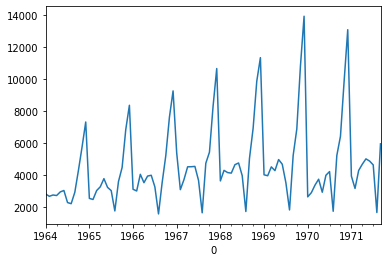

In [4]:
# line plot of time series
from matplotlib import pyplot

series.plot()
pyplot.show()

**Seasonal Line Plots:** This plot seperates all 7 years of sales data into individual year and creates one line plot each. This way, we can spot any year on year seasonality.

 Some Observations:

 * We can see a slight dip in month 8 of each year, followed by an increase from month 8-12 every year

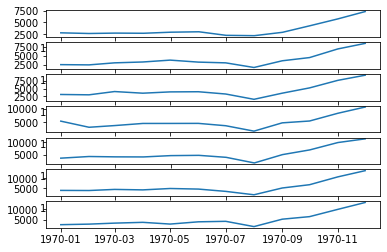

In [5]:
# multiple line plots of time series
from pandas import DataFrame
from pandas import Grouper

groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
  pyplot.subplot((n_groups*100) + 10 + i)
  i += 1
  pyplot.plot(group)
pyplot.show()

**Density Plot:** This plot shows the distribution of the datapoints.

Some observations#

* The distribution is not gaussian, it has a long right tail and might suggest an exponential distribution. Power transformation is most definetly needed.

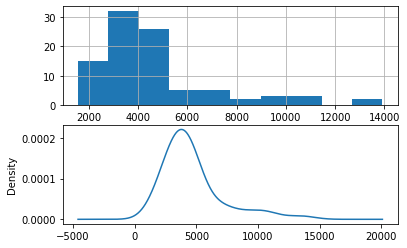

In [6]:
# density plots of time series

pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

**Box and Whisker Plot:** This plot shows the spread of the data and we can observe how it is changing. Note: The final year, 1971, has only up to 9 months of datapoints, which would not be a useful comparison.

Some observations:

* The median (green line) may show an increasing trend
* There are outliers each year
* Year 1970 seems to deviate slightly from the trend pattern compared to prior years

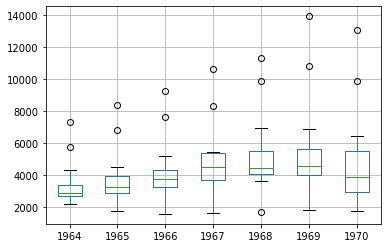

In [7]:
# boxplots of time series

groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()
pyplot.show()

# ARIMA Modelling

ARIMA model assumes that the time series is stationary. We will first do a differencing, followed by a statistical test (Augmented Dicky Fuller, ADF) to confirm stationarity. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, this means we will lose the first year of observations as there is no prior year to difference with.

**Differencing the time series**

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


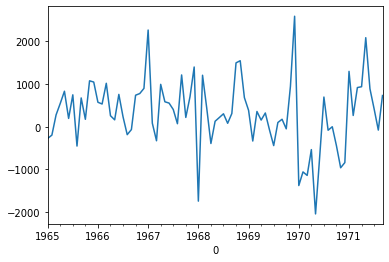

In [8]:
# create and summarize stationary version of time series
from pandas import Series
from statsmodels.tsa.stattools import adfuller

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return Series(diff)

series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]

# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

# save as csv
stationary.to_csv('stationary.csv', header=False)

# plot
stationary.plot()
pyplot.show()

The ADF statistics shows a value of -7.134898, which is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significant value of 1%, which means that this series has no unit root, or does not have a time dependent structure.

A plot of the differenced dataset is also created, and it does not show any obvious trend or seasonality. This suggests that no furthur differencing may be required, and the d parameter may be set to 0. We can now use this differenced dataset for ARIMA modelling.

**ACF and PACF plots:** Ths next step is to select the lag values for the Autoregression (AR, p) and the Moving Average (MA, q) portion of the ARIMA model.

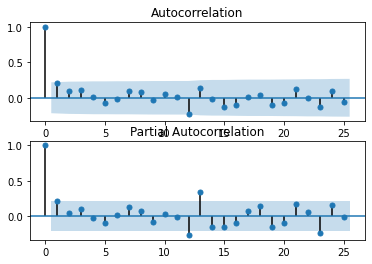

In [9]:
# ACF and PACF plots of time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = read_csv('/content/stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=25, ax=pyplot.gca())
pyplot.show()

In [10]:
# evaluate manually configured ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):

  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)

  # predict
  model = ARIMA(diff, order=(1,1,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8089.892, Expected=8314.000
>Predicted=9742.786, Expected=10651.000
>Predicted=5986.916, Expected=3633.000
>Predicted=3886.954, Expected=4292.000
>Predicted=4038.120, Expected=4154.000
>Predicted=4992.340, Expected=4121.000
>Predicted=5156.385, Expected=4647.000
>Predicted=5046.669, Expected=4753.000
>Predicted=4143.877, Expected=3965.000
>Predicted=2102.942, Expected=1723.000
>Predicted=5228.292, Expected=5048.000
>Predicted=5873.444, Expected=6922.000
>Predicted=8571.264, Expected=9858.000
>Predicted=11006.038, Expected=11331.000
>Predicted=4087.455, Expected=4016.000
>Predicted=4771.842, Expected=3957.000
>Predicted=4676.086, Expected=4510.000
>Predicted=4583.396, Expected=4276.000
>Predicted=5117.345, Expected=4968.000
>Predicted=5208.150, Expected=4677.000
>Predicted=4436.445, Expected=3523.000
>Predicted=2180.952, Expected=1821.000
>Predicted=5471.264, Expected=5222.000
>Predicted=7337.610, Expected=6872.000
>Predicted=10268.369, Expected=10803.000
>Predicted=11725.422

In [11]:
# grid search ARIMA parameters for time series
import warnings
import numpy

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):

  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):

    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    model = ARIMA(diff, order=arima_order)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(test[t])

  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.792
ARIMA(0, 0, 5) RMSE=986.834
ARIMA(0, 0, 6) RMSE=1087.017
ARIMA(0, 1, 1) RMSE=958.297
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.960
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 0, 1) RMSE=948.621
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.923
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.636
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.939
ARIMA(3, 2, 0) RMSE=1244.847
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 0, 1) RMSE=911.526
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.254
ARIMA(4, 1, 2) RMSE=993.647
ARIMA(4, 2, 0) RMSE=1227.555
ARIMA(4, 2, 1) RMSE=1055.488
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.404
ARIMA(5, 1, 2) RMSE=1003.165
ARIMA(5, 2, 1) RMSE=1053.730
ARIMA(6, 0, 0) RMSE=996.466
ARI

**Reviewing Residual Errors**

                 0
count    47.000000
mean    146.401198
std     909.419286
min   -1908.837221
25%    -319.648151
50%     116.848304
75%     552.848090
max    2400.721373


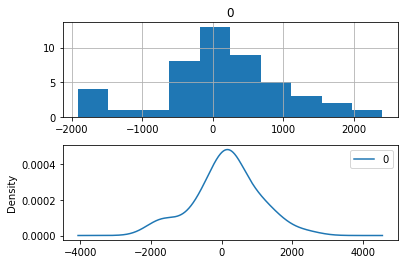

In [12]:
# summarize ARIMA forecast residuals

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):

  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)

  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

**Bias Correction**

RMSE: 899.904
                 0
count    47.000000
mean    -19.503530
std     909.419286
min   -2074.741949
25%    -485.552879
50%     -49.056424
75%     386.943362
max    2234.816645


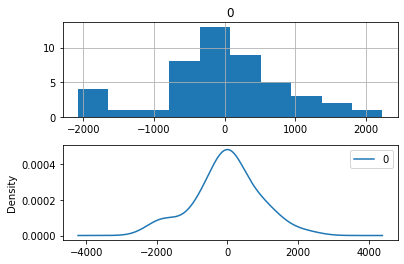

In [13]:
# plots of residual errors of bias corrected forecasts
from pandas import DataFrame

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):

  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)

  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

                 0
count    47.000000
mean    146.401198
std     909.419286
min   -1908.837221
25%    -319.648151
50%     116.848304
75%     552.848090
max    2400.721373


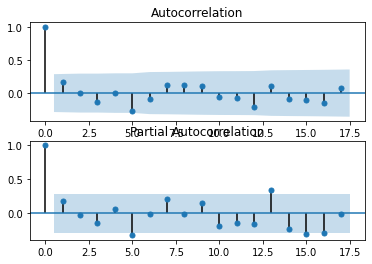

In [16]:
# ACF and PACF plots of residual errors of bias corrected forecasts

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load data
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):

  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)

  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)

  # observation
  obs = test[i]
  history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [17]:
# save finalized model

# monkey patch around bug in ARIMA class
#def __getnewargs__(self):
#  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
#ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# load data
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = series.values
X = X.astype('float32')

# difference data
months_in_year = 12
diff = difference(X, months_in_year)

# fit model
model = ARIMA(diff, order=(4,0,1))
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = 165.904728

# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [18]:
# load finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]
series = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('/content/model.pkl')
bias = numpy.load('/content/model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6834.315


>Predicted=6834.315, Expected=6981.000
>Predicted=10203.011, Expected=9851.000
>Predicted=13400.018, Expected=12670.000
>Predicted=4074.862, Expected=4348.000
>Predicted=3404.328, Expected=3564.000
>Predicted=4524.051, Expected=4577.000
>Predicted=5009.666, Expected=4788.000
>Predicted=5286.797, Expected=4618.000
>Predicted=4986.750, Expected=5312.000
>Predicted=4899.852, Expected=4298.000
>Predicted=1713.218, Expected=1413.000
>Predicted=6093.397, Expected=5877.000
RMSE: 396.091


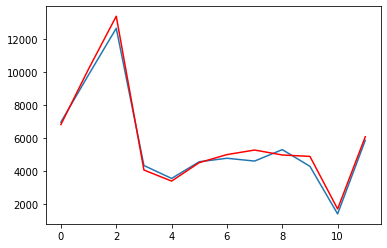

In [19]:
# load and evaluate the finalized model on the validation dataset

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# load and prepare datasets
dataset = read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('/content/validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('/content/model.pkl')
bias = numpy.load('/content/model_bias.npy')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):

  # difference data
  months_in_year = 12
  diff = difference(history, months_in_year)

  # predict
  model = ARIMA(diff, order=(4,0,1))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = model_fit.forecast()[0]
  yhat = bias + inverse_difference(history, yhat, months_in_year)
  predictions.append(yhat)

  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()